In [1]:
# %matplotlib inline

In [2]:
# %pip install gymnasium


# Solving Blackjack with Q-Learning


In this project, we’ll explore and solve the *Blackjack-v1*
environment.

**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - stand (0): the player takes no more cards
 - hit (1): the player will be given another card, however the player could get over 21 and bust

**Approach**: To solve this environment by yourself, you can pick your
favorite discrete RL algorithm. The presented solution uses *Q-learning*
(a model-free RL algorithm).




## Imports and Environment Setup




In [3]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True)

**Other possible environment configurations are**:

```python
  env = gym.make('Blackjack-v1', natural=True, sab=False)
  # Whether to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

  env = gym.make('Blackjack-v1', natural=False, sab=False)
  # Whether to follow the exact rules outlined in the book by Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
```



## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




In [4]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# observation = (16, 9, False)

Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)




## Executing an action

After receiving our first observation, we are only going to use the
``env.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the environment, but in the Blackjack-v1
environment you can ignore it. For example in Atari environments the
info dictionary has a ``ale.lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call ``env.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.




In [5]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).




## Building an agent

Let’s build a ``Q-learning agent`` to solve *Blackjack-v1*! We’ll need
some functions for picking an action and updating the agents action
values. To ensure that the agents explores the environment, one possible
solution is the ``epsilon-greedy`` strategy, where we pick a random
action with the percentage ``epsilon`` and the greedy action (currently
valued as the best) ``1 - epsilon``.




In [6]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each episode. The agent will have to experience a lot of episodes to
explore the environment sufficiently.

Now we should be ready to build the training loop.




In [7]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent.
If you want to converge to the optimal policy, try increasing
the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).




In [8]:
env = gym.wrappers.RecordEpisodeStatistics(env)
episode_rewards = []
episode_lengths = []

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(obs, action, reward, terminated, next_obs)
        total_reward += reward
        steps += 1
        obs = next_obs
        done = terminated or truncated

    episode_rewards.append(total_reward)
    episode_lengths.append(steps)
    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:22<00:00, 4542.54it/s]



| Attribute              | Type    | Meaning                                |
| ---------------------- | ------- | -------------------------------------- |
| `env.return_queue`     | `deque` | Stores total episodic rewards          |
| `env.length_queue`     | `deque` | Stores episode lengths (in steps)      |
| `env.episode_count`    | `int`   | Number of episodes recorded            |
| `info["episode"]["r"]` | `float` | Reward for that episode (if done=True) |
| `info["episode"]["l"]` | `int`   | Length of that episode                 |
| `info["episode"]["t"]` | `float` | Duration in seconds                    |


## Visualizing the training




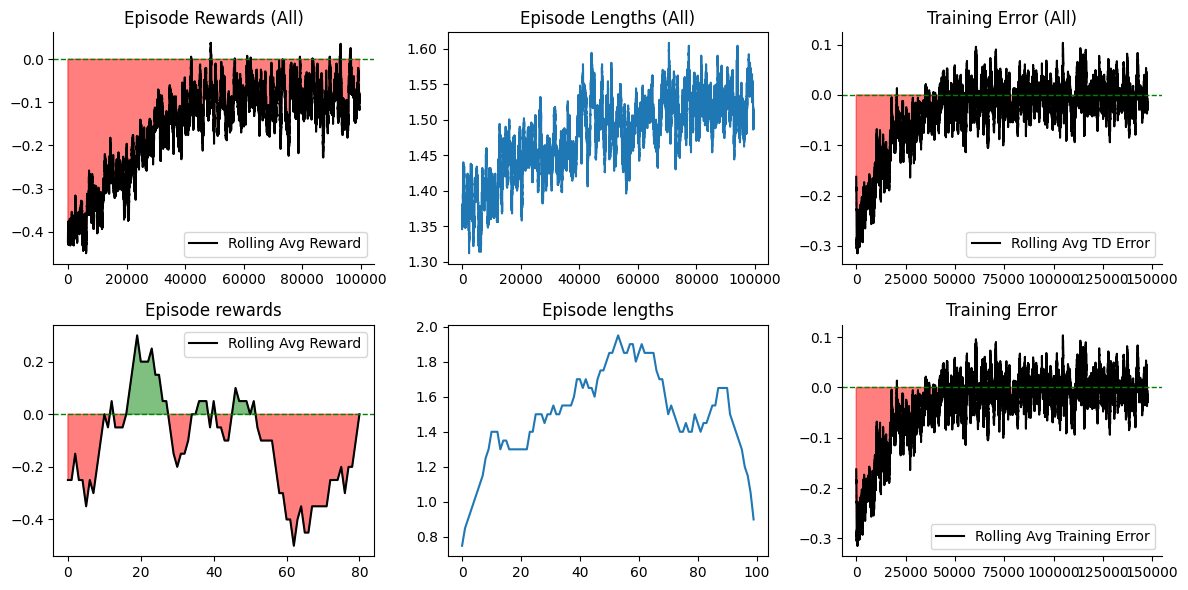

In [9]:
rolling_length = 500
rolling_length_wraper = 20
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

# ---------------- Row 1: Full training history (rolling average) ----------------

# Rewards (all episodes, rolling average)
reward_ma = np.convolve(
    np.array(episode_rewards),
    np.ones(rolling_length) / rolling_length,
    mode='valid'
)

x = np.arange(len(reward_ma))
y = reward_ma

# Plot the main rolling average line
axs[0, 0].plot(x, y, color='black', linewidth=1.5, label='Rolling Avg Reward')

# Add a horizontal dotted green line at y=0
axs[0, 0].axhline(0, color='green', linestyle='--', linewidth=1)

# Fill green above zero, red below zero
axs[0, 0].fill_between(x, y, 0, where=(y > 0), color='green', alpha=0.5, interpolate=True)
axs[0, 0].fill_between(x, y, 0, where=(y < 0), color='red', alpha=0.5, interpolate=True)

axs[0, 0].set_title("Episode Rewards (All)")
axs[0, 0].legend()

# Optional: cleaner look
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)

# Episode lengths (all episodes, rolling average)
length_ma = np.convolve(np.array(episode_lengths), np.ones(rolling_length)/rolling_length, mode='valid')
axs[0, 1].plot(range(len(length_ma)), length_ma)
axs[0, 1].set_title("Episode Lengths (All)")

# Training error / temporal difference (all steps, rolling average)
td_ma = np.convolve(np.array(agent.training_error), np.ones(rolling_length)/rolling_length, mode='same')
axs[0, 2].plot(range(len(td_ma)), td_ma, color='black', linewidth=1.5, label='Rolling Avg TD Error')

axs[0, 2].axhline(0, color='green', linestyle='--', linewidth=1)

# Fill green where TD error is above zero, red where below zero
x = range(len(td_ma))
y = td_ma
axs[0, 2].fill_between(x, y, 0, where=(y > 0), color='green', alpha=0.5, interpolate=True)
axs[0, 2].fill_between(x, y, 0, where=(y < 0), color='red', alpha=0.5, interpolate=True)

axs[0, 2].set_title("Training Error (All)")
axs[0, 2].legend()

# Optional cosmetic tweaks
axs[0, 2].spines['top'].set_visible(False)
axs[0, 2].spines['right'].set_visible(False)


# ---------------- Row 2: Last 100 fixed episodes for the env.wraper ----------------
axs[1, 0].set_title("Episode rewards")

# Compute rolling average
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length_wraper), mode="valid"
    ) / rolling_length_wraper
)

x = np.arange(len(reward_moving_average))
y = reward_moving_average

# Plot main line
axs[1, 0].plot(x, y, color="black", linewidth=1.5, label="Rolling Avg Reward")

# Add a horizontal dotted green line at y=0
axs[1, 0].axhline(0, color="green", linestyle="--", linewidth=1)

# Fill green where above zero, red where below zero
axs[1, 0].fill_between(x, y, 0, where=(y > 0), interpolate=True, color="green", alpha=0.5)
axs[1, 0].fill_between(x, y, 0, where=(y < 0), interpolate=True, color="red", alpha=0.5)

axs[1, 0].legend()


axs[1, 1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length_wraper), mode="same"
    )
    / rolling_length_wraper
)
axs[1, 1].plot(range(len(length_moving_average)), length_moving_average)

training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")/rolling_length)
axs[1, 2].plot(range(len(training_error_moving_average)), training_error_moving_average, color='black', linewidth=1.5, label='Rolling Avg Training Error')

axs[1, 2].axhline(0, color='green', linestyle='--', linewidth=1)

# Fill green where above zero, red where below zero
x = range(len(training_error_moving_average))
y = training_error_moving_average
axs[1, 2].fill_between(x, y, 0, where=(y > 0), color='green', alpha=0.5, interpolate=True)
axs[1, 2].fill_between(x, y, 0, where=(y < 0), color='red', alpha=0.5, interpolate=True)

axs[1, 2].set_title("Training Error")
axs[1, 2].legend()

# Optional: minimalist style
axs[1, 2].spines['top'].set_visible(False)
axs[1, 2].spines['right'].set_visible(False)



plt.tight_layout()
plt.show()


## Visualising the policy



In [19]:
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


"""Creates a plot using a value and policy grid."""
# create a new figure with 2 subplots (left: state values, right: policy)
def create_plots(value_grid, policy_grid, title: str):
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="white", label="Hit"),
        Patch(facecolor="grey", edgecolor="white", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

## Understanding the create_grids and create_plots:


### 🧩 Step 1. What the goal is

We want to make 2D grids that map:

* the **player’s sum** (12–21)
* the **dealer’s visible card** (1–10)

to:

* **value_grid** → how good that state is (expected return)
* **policy_grid** → what action to take (e.g. hit or stick)

And we want these grids to be in the right format for plotting — something that matches the shape of the state space.

---

### 🧮 Step 2. Generate the coordinate grid

```python
player_count, dealer_count = np.meshgrid(
    np.arange(12, 22),   # player sum from 12 to 21
    np.arange(1, 11),    # dealer visible card 1 to 10
)
```

Let’s see what these look like:

```python
print(player_count)
```

```
[[12 13 14 15 16 17 18 19 20 21]
 [12 13 14 15 16 17 18 19 20 21]
 ...
 (10 rows total)
]
```

```python
print(dealer_count)
```

```
[[ 1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2]
 ...
 (10 rows total)
]
```

So each position `(i, j)` in these arrays represents a **state**:

> player sum = player_count[i, j], dealer card = dealer_count[i, j]

---

### 🧱 Step 3. Combine them with `np.dstack`

```python
np.dstack([player_count, dealer_count])
```

This “**depth stack**” combines the two (10×10) arrays along a new third dimension → shape `(10, 10, 2)`.

Example for the top-left few elements:

```
[
  [[12, 1], [13, 1], [14, 1], ...],
  [[12, 2], [13, 2], [14, 2], ...],
  ...
]
```

So now each element is a **pair** `[player_sum, dealer_card]`.

---

### 🧠 Step 4. Apply a function to every [player, dealer] pair

Now we use:

```python
np.apply_along_axis(
    lambda obs: state_value[(obs[0], obs[1], usable_ace)],
    axis=2,
    arr=np.dstack([player_count, dealer_count]),
)
```

Let’s break that down carefully:

* `arr` = `(10, 10, 2)` array of pairs `[player_sum, dealer_card]`
* `axis=2` → means: apply the function **along the last axis** (i.e., treat each `[player_sum, dealer_card]` as a vector to feed into the function)
* The function:

  ```python
  lambda obs: state_value[(obs[0], obs[1], usable_ace)]
  ```

  * takes one `[player_sum, dealer_card]` vector,
  * and looks up its value in a dictionary `state_value` using the tuple `(player_sum, dealer_card, usable_ace)`.

So if `obs = [15, 6]` and `usable_ace = True`,
then the lookup is `state_value[(15, 6, True)]`.

---

### 📊 Step 5. The result

After `np.apply_along_axis`, you get a **10×10 array** of values — one per (player, dealer) combination.

That’s your **value grid** for that `usable_ace` condition.

So:

```python
value_grid = player_count, dealer_count, value
```

is just grouping them into a tuple for plotting (since you need X, Y, and Z for 3D plotting).

---

### 🎯 Step 6. Do the same for the policy

```python
policy_grid = np.apply_along_axis(
    lambda obs: policy[(obs[0], obs[1], usable_ace)],
    axis=2,
    arr=np.dstack([player_count, dealer_count]),
)
```

Here it’s identical, except instead of looking up the **state value**, it looks up the **best action** from `policy`.

So `policy_grid[i, j]` tells you which action (e.g., `0=stick`, `1=hit`) to take for that (player_sum, dealer_card).

---

### 🧠 Visualization summary

| Variable       | Shape    | Meaning                    | Example Element                       |
| -------------- | -------- | -------------------------- | ------------------------------------- |
| `player_count` | (10, 10) | player sum grid            | 12–21 repeated                        |
| `dealer_count` | (10, 10) | dealer card grid           | 1–10 tiled                            |
| `value`        | (10, 10) | expected value of state    | -0.1, +0.2, etc.                      |
| `value_grid`   | tuple    | (X, Y, Z) for 3D plotting  | `(player_count, dealer_count, value)` |
| `policy_grid`  | (10, 10) | best action for each state | 0 or 1                                |


## state values & policy with usable ace (ace counts as 11)

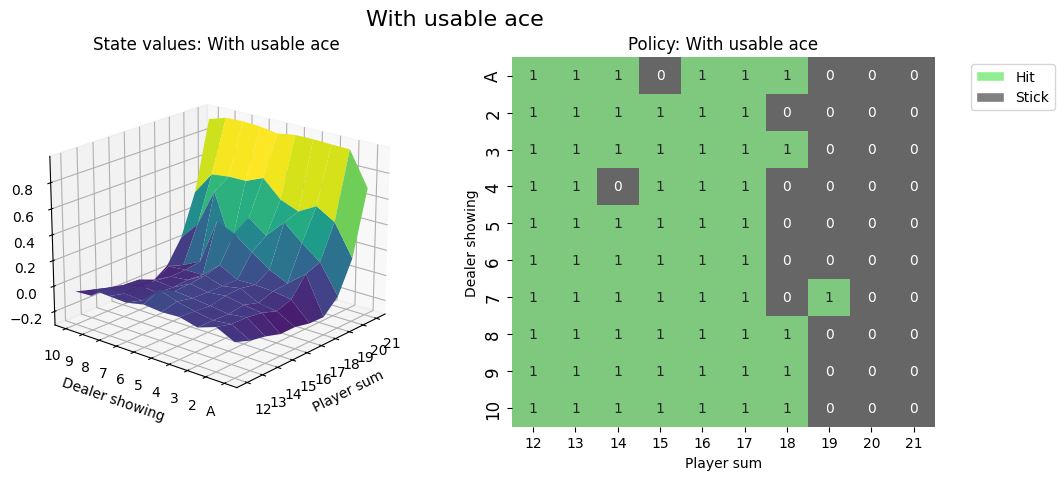

In [20]:
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

## tate values & policy without usable ace (ace counts as 1)

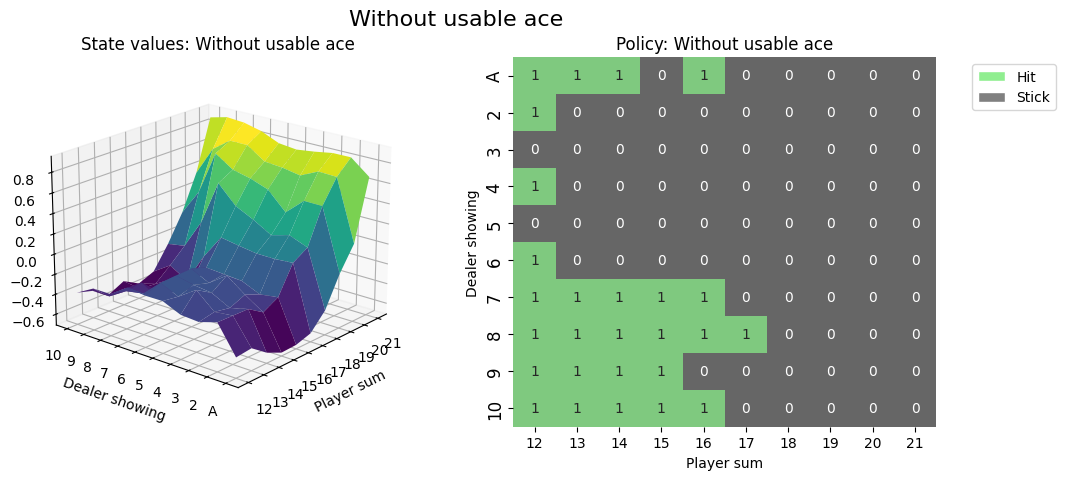

In [12]:
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

It's good practice to call env.close() at the end of your script,
so that any used resources by the environment will be closed.


